In [1]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop, Grayscale
import matplotlib.pyplot as plt
import time
import dataset as data
import model as md
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(DEVICE))

Using cpu device


In [2]:
## Hyperparameters
Batch_size = 4
Optimizer_type = 'SGD'
Learning_rate = 1e-3
Weight_decay = 0
epochs = 15

In [3]:
def Sample_visualize(dataloader) :
  ## Visualize some preprocess images
  ##
  ## Input : dataloader of image dataset
  ## Output : image plots

 dataiter = iter(dataloader)
 images, labels = next(dataiter)
 images = images.numpy()
 for i in range (2) :
   plt.subplot(1,4,i+1)
   plt.imshow(images[i].reshape(32,96), cmap='gray')
   plt.xticks([])
   plt.yticks([])

   print(labels)

In [4]:
train_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset', label_file='./CNN_generated_dataset/Labels.csv')
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

# val_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset_val', label_file='./CNN_generated_dataset_val/Labels.csv')
# val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)
#
# test_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset_test', label_file='./CNN_generated_dataset_test/Labels.csv')
# test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)

[tensor([23,  4, 18, 34]), tensor([ 4, 31, 25, 12]), tensor([12,  5, 17,  8]), tensor([ 9, 19,  7, 29]), tensor([32, 32, 21,  8]), tensor([28, 35, 30, 25]), tensor([ 6, 35, 30, 15]), tensor([16, 35, 22, 33]), tensor([ 7, 35, 28, 35]), tensor([15, 35,  4, 35]), tensor([12, 35, 35, 35])]
[tensor([23,  4, 18, 34]), tensor([ 4, 31, 25, 12]), tensor([12,  5, 17,  8]), tensor([ 9, 19,  7, 29]), tensor([32, 32, 21,  8]), tensor([28, 35, 30, 25]), tensor([ 6, 35, 30, 15]), tensor([16, 35, 22, 33]), tensor([ 7, 35, 28, 35]), tensor([15, 35,  4, 35]), tensor([12, 35, 35, 35])]


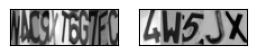

In [5]:
Sample_visualize(train_loader)

In [6]:
model = md.CNN(init_weights=False)
model.to(DEVICE)
print(model)

CNN(
  (localization): Sequential(
    (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3360, out_features=50, bias=True)
    (10): ReLU()
    (11): Linear(in_features=50, out_features=6, bias=True)
    (12): ReLU()
  )
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [7]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

if Optimizer_type == 'ADAM' :
  optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)
elif Optimizer_type == 'SGD' :
  optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)

In [8]:
## Training function ##
def train(dataloader, model, loss_fn, optimizer):
  for batch_idx, (X,y) in enumerate(dataloader):

    X = X.to(DEVICE)
    pred = model(X)
    loss = 0.
    for idx in range(11):
      y[idx] = y[idx].to(DEVICE)
      loss += loss_fn(torch.tensor(pred[idx], dtype=torch.float32), y[idx])

    optimizer.zero_grad()
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()

    if batch_idx % 5 == 0:
      print('loss: {:.6f} [{}/{}]'.format(loss.item(), batch_idx*len(X), len(dataloader.dataset)))

In [9]:
## Validation function ##
def validation(model, valdata):
  ## Input : trained model, validation data
  ## Output : validation loss

  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in valdata:
      X = X.to(DEVICE)
      pred = model(X)
      for idx in range(11):
        y[idx] = y[idx].to(DEVICE)
        pred[idx] = pred[idx].squeeze()
        val_loss += loss_fn(torch.tensor(torch.argmax(pred[idx], dim=-1), dtype=torch.float32), torch.tensor(y[idx], dtype=torch.float32))
      pred = pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
  val_loss /= len(valdata.dataset)
  print('\n***Validation Result***\nAverage loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(val_loss, correct, len(valdata.dataset), 100*correct/len(valdata.dataset)))

In [10]:
## Training Operation ##
start = time.time()
for t in range(epochs):
  print(f"\n[Epoch {t+1}]")
  train(train_loader, model, loss_fn, optimizer)
  # validation(model, val_loader)
print("\nDone!")
end = time.time()

print("Training time: {:.4f}".format(end-start))


[Epoch 1]
loss: 39.715469 [0/1000]
loss: 39.751678 [20/1000]
loss: 39.734108 [40/1000]


C:\Users\Wonjoon_LAB\PycharmProjects\AIGS538_Carplate_letter_sequence_geneneration\venv\lib\site-packages\torch\nn\functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\Wonjoon_LAB\PycharmProjects\AIGS538_Carplate_letter_sequence_geneneration\venv\lib\site-packages\torch\nn\functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\Wonjoon_LAB\PycharmProjects\AIGS538_Carplate_letter_sequence_geneneration\venv\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an ar

loss: 39.711449 [60/1000]
loss: 39.731693 [80/1000]
loss: 39.704437 [100/1000]
loss: 39.728943 [120/1000]
loss: 39.726768 [140/1000]
loss: 39.730057 [160/1000]
loss: 39.725296 [180/1000]
loss: 39.747025 [200/1000]
loss: 39.746658 [220/1000]
loss: 39.736149 [240/1000]
loss: 39.706173 [260/1000]
loss: 39.691315 [280/1000]
loss: 39.724220 [300/1000]
loss: 39.725029 [320/1000]
loss: 39.715622 [340/1000]
loss: 39.711304 [360/1000]
loss: 39.743328 [380/1000]
loss: 39.734100 [400/1000]
loss: 39.722099 [420/1000]
loss: 39.732361 [440/1000]
loss: 39.714367 [460/1000]
loss: 39.736221 [480/1000]
loss: 39.736687 [500/1000]
loss: 39.736885 [520/1000]
loss: 39.715935 [540/1000]
loss: 39.721775 [560/1000]
loss: 39.732445 [580/1000]
loss: 39.728203 [600/1000]
loss: 39.717705 [620/1000]
loss: 39.718407 [640/1000]
loss: 39.743904 [660/1000]
loss: 39.702164 [680/1000]
loss: 39.732151 [700/1000]
loss: 39.689301 [720/1000]
loss: 39.730026 [740/1000]
loss: 39.719406 [760/1000]
loss: 39.715527 [780/1000]
los